In [1]:
# Imports
import os
from pkg_resources import resource_filename
import os
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

# ASTR 257
from astr257 import img_utils

# Personal utils
from utils import *

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
rcParams["font.family"] = "serif"
rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
#%matplotlib notebook
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{bm} \usepackage{physics}']
%config InlineBackend.figure_format = 'retina' # For high quality figures
%load_ext autoreload
%autoreload 2

In [2]:
data_folder = "data-2019-09-23-nickel-joey-anne"
OVERWRITE = False

# Load the calibrated, corrected science images

In [3]:
ngc6819_v = fits.getdata(os.path.join(data_folder, 'masters/ngc6819_v_master_full_cal_nobadcol.fits'))
ngc6819_v_header = fits.getheader(os.path.join(data_folder, 'masters/ngc6819_v_master_full_cal_nobadcol.fits'))

ngc6819_b = fits.getdata(os.path.join(data_folder, 'masters/ngc6819_b_master_full_cal_nobadcol.fits'))
ngc6819_b_header = fits.getheader(os.path.join(data_folder, 'masters/ngc6819_b_master_full_cal_nobadcol.fits'))

landolt_v = fits.getdata(os.path.join(data_folder, 'masters/landolt_v_master_full_cal_nobadcol.fits'))
landolt_v_header = fits.getheader(os.path.join(data_folder, 'masters/landolt_v_master_full_cal_nobadcol.fits'))

landolt_b = fits.getdata(os.path.join(data_folder, 'masters/landolt_b_master_full_cal_nobadcol.fits'))
landolt_b_header = fits.getheader(os.path.join(data_folder, 'masters/landolt_b_master_full_cal_nobadcol.fits'))

# Look at one of the calibrated images

In [4]:
wcs_v = WCS(ngc6819_v_header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


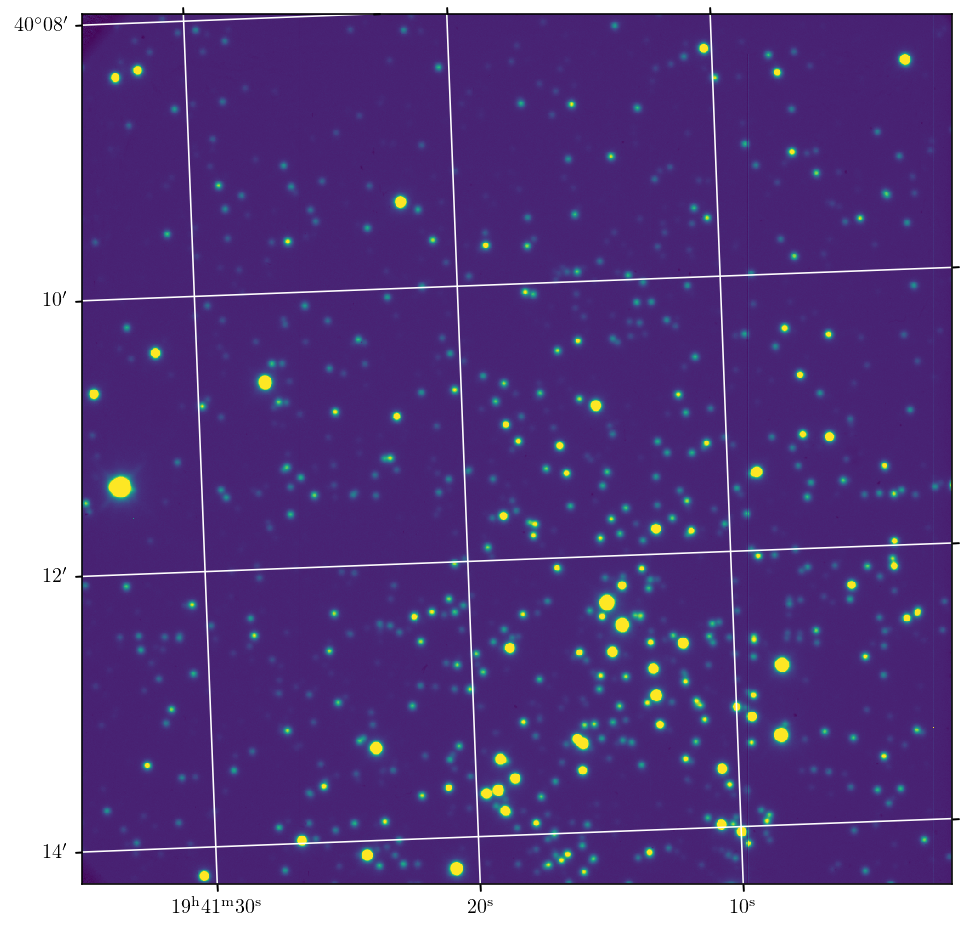

In [5]:
plt.figure(figsize=(8, 8))
plt.subplot(projection=wcs_v)
plt.imshow(ngc6819_v, vmin=0, vmax=3000)
plt.grid(color='white', ls='solid')
plt.show()

# Source detection
See: https://photutils.readthedocs.io/en/stable/index.html

In [6]:
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder

mean_v, median_v, std_v = sigma_clipped_stats(ngc6819_v, sigma=3.0) # Background statistics

daofind = DAOStarFinder(fwhm=5.0, threshold=5.*std_v)
sources_v = daofind(ngc6819_v)
for col in sources_v.colnames:
    sources_v[col].info.format = '%.8g'  # for consistent table output
print(sources_v)

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
  1 3.3437169 2.1710419 0.66518352 ...   0 217.42157  1.737999  -0.60012378
  2 256.94842 3.0985177 0.30399973 ...   0 271.61405 1.7737657  -0.62224064
  3 572.73047 2.2183541 0.41263767 ...   0 1238.2204 12.581216   -2.7493066
  4 1001.9555 2.7793577 0.73022484 ...   0 409.11666 2.4846556  -0.98816551
  5 143.38699 9.1574238 0.42709529 ...   0 13351.361 108.06064   -5.0841688
  6 535.07916 13.889464 0.45479567 ...   0 679.96433 3.0956507   -1.2268799
  7 590.41893 13.767914 0.39164817 ...   0 2978.0351 22.975853   -3.4031791
  8 921.61137  15.06994  0.3817743 ...   0 1513.2254 11.140316   -2.6172437
  9 238.63678 15.541039    0.41633 ...   0 1603.7654 11.168391   -2.6199765
 10 882.54321 17.381844 0.35343585 ...   0 473.05801 1.8557632  -0.67130639
...       ...       ...        ... ... ...       ...       ...          ...
724 171.6282

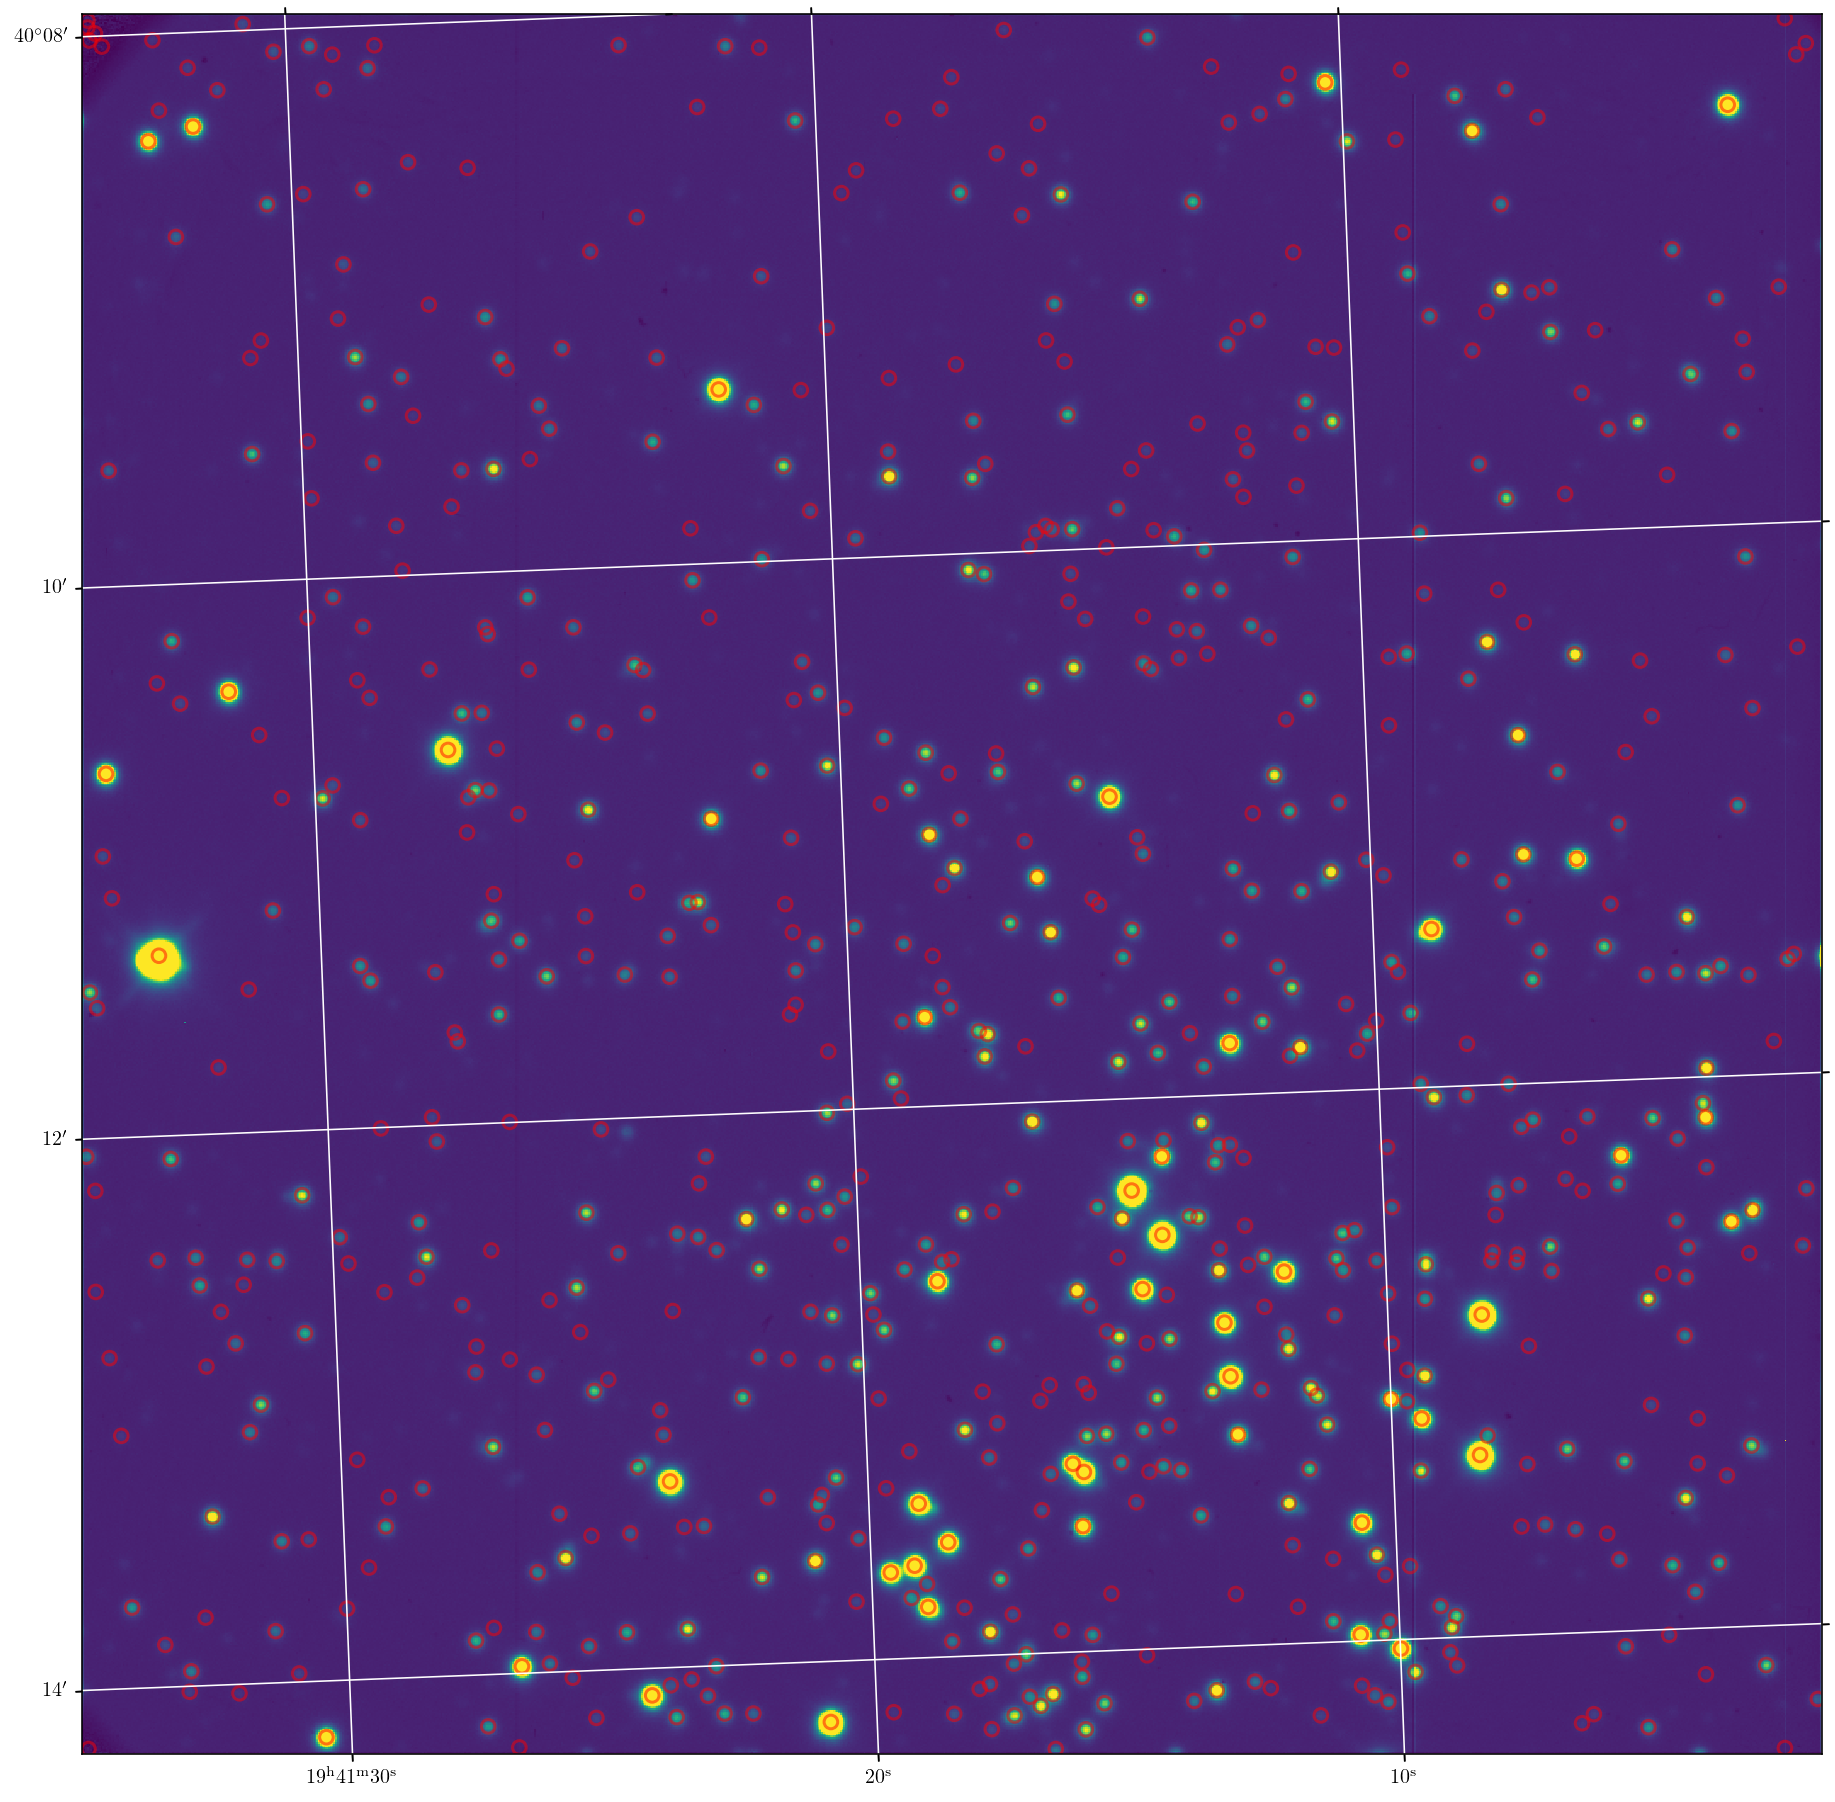

In [7]:
from photutils import CircularAperture

positions_v = np.transpose((sources_v['xcentroid'], sources_v['ycentroid']))
apertures_v = CircularAperture(positions_v, r=4.)

plt.figure(figsize=(16, 16))
plt.subplot(projection=wcs_v)
plt.grid(color='white', ls='solid')
plt.imshow(ngc6819_v, origin='lower', vmin=0, vmax=3000)
apertures_v.plot(color='red', lw=1.5, alpha=0.5)

## How to improve source detection?
Above is using DOAStarFinder

What "detected" sources are false positives?
1. Vignetting 

    **Solution**: Run DOAStarFinder on a subselection of the image, excluding a boarder around the edge of the image.
    - How large to make border?
    
2. Saturated sources?

    **Solution**: Set the maximum source brightness to 50,000. (recommended Nickel max exposure counts before saturation at $2^{16}$).


In [8]:
DAOStarFinder?

In [9]:
mean_v, median_v, std_v = sigma_clipped_stats(ngc6819_v, sigma=3.0) # Background statistics

# Adjust these params by hand/eye
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std_v, sharplo=0.0, sharphi=0.5, 
                        roundlo=-0.2, roundhi=0.2, peakmax=5e4, exclude_border=True)
sources_v = daofind(ngc6819_v - median_v)
for col in sources_v.colnames:
    sources_v[col].info.format = '%.8g'  # for consistent table output
print(sources_v)

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
  1 143.35212 9.1571939 0.40874652 ...   0 12877.242 32.290006   -3.7726703
  2 535.01009 13.916704  0.4188065 ...   0 378.94889 1.0524402 -0.055493577
  3 590.37276 13.775664 0.34722236 ...   0 2644.1912 6.3745064   -2.0111164
  4 440.35432 18.137437 0.41645396 ...   0 39287.159  100.2505   -5.0027164
  5 349.59645 21.009628 0.32530403 ...   0 1630.6669 4.0855958   -1.5281385
  6 377.73589 23.124704 0.47664187 ...   0 1609.0346 4.3311413   -1.5915059
  7 394.78188 23.116244 0.36072613 ...   0 652.40885 1.6619676  -0.55155636
  8 563.89782 27.717629 0.38889609 ...   0 3045.0081 6.8662614   -2.0918008
  9 601.41376 29.162382 0.34497476 ...   0 2044.9028 5.1167776   -1.7724914
 10 654.24705 30.487961 0.36706802 ...   0  884.9644 2.6954585   -1.0765816
...       ...       ...        ... ... ...       ...       ...          ...
359 419.3164

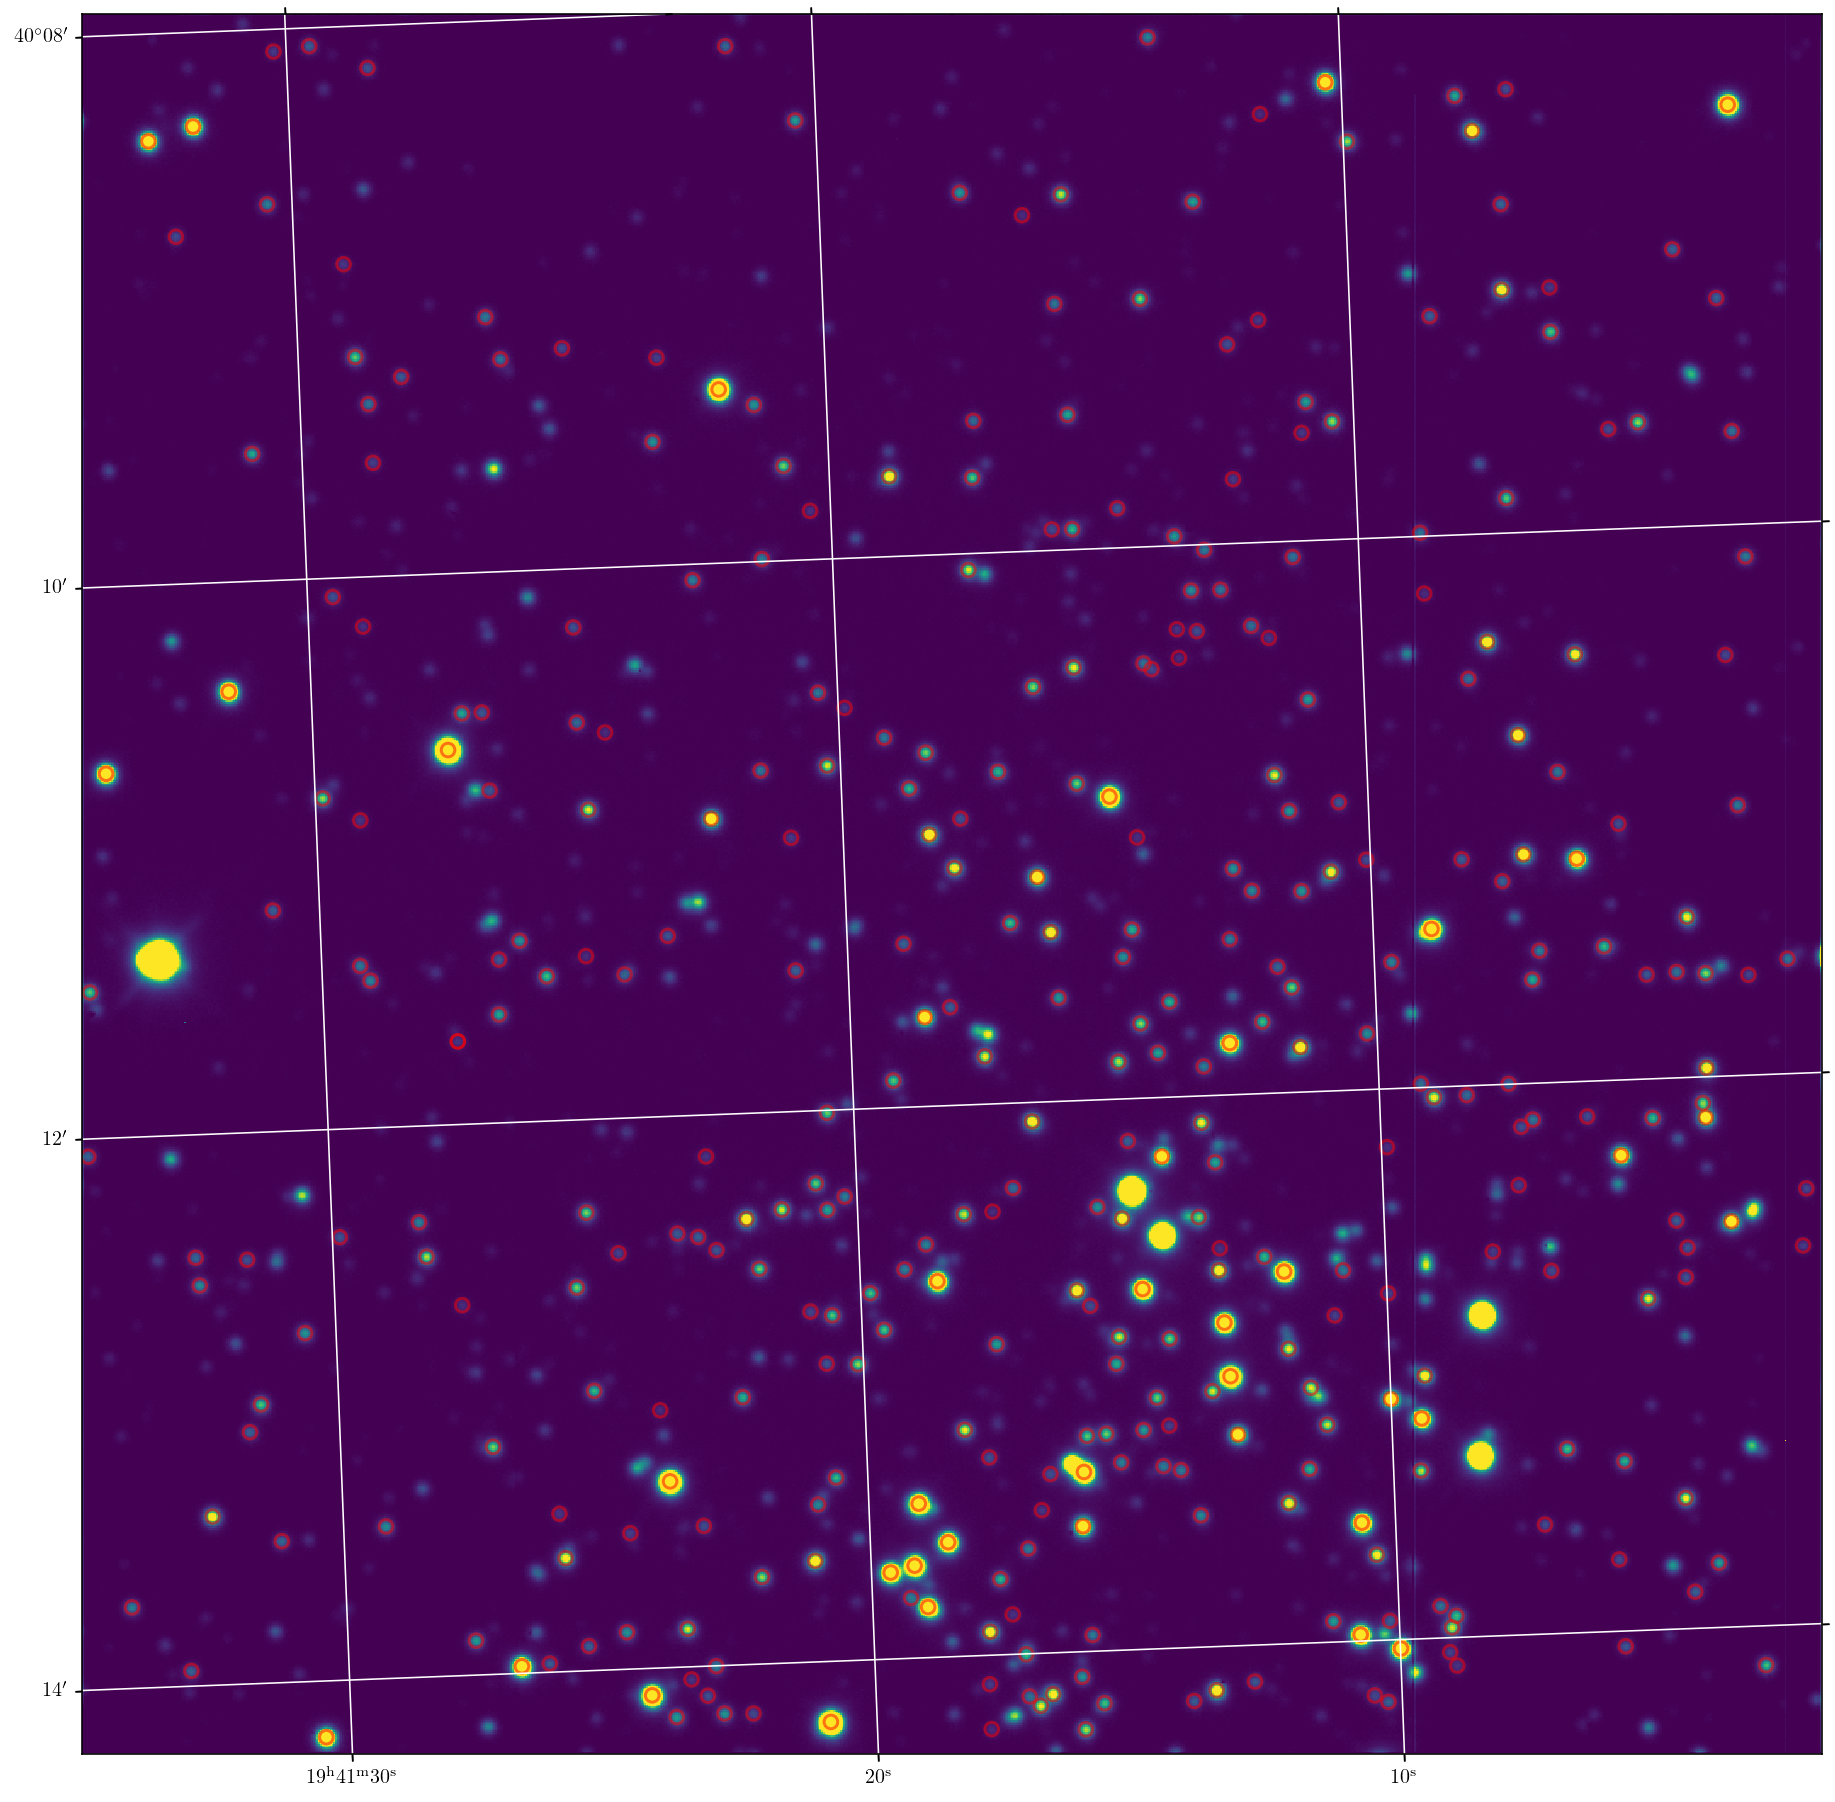

In [59]:
positions_v = np.transpose((sources_v['xcentroid'], sources_v['ycentroid']))
apertures_v = CircularAperture(positions_v, r=4.)

plt.figure(figsize=(16, 16))
plt.subplot(projection=wcs_v)
plt.grid(color='white', ls='solid')
plt.imshow(ngc6819_v - median_v, origin='lower', vmin=0, vmax=3000)
apertures_v.plot(color='red', lw=1.5, alpha=0.5)

    - Good DOAStarFinder() params for ngc6819_v: daoStarFinder(fwhm=3.0, threshold=5.*std_v, sharplo=0.0, sharphi=0.5, roundlo=-0.2, roundhi=0.2, peakmax=5e4, exclude_border=True)

### Trying same params on ngc6819_b now:

In [32]:
wcs_b = WCS(ngc6819_b_header)

mean_b, median_b, std_b = sigma_clipped_stats(ngc6819_b, sigma=3.0) # Background statistics

# Adjust these params by hand/eye
daofind = DAOStarFinder(fwhm=3.0, threshold=3.*std_v, sharplo=0.0, sharphi=.5, 
                        roundlo=-0.2, roundhi=0.2, peakmax=5e4, exclude_border=True)
sources_b = daofind(ngc6819_b - median_b)
for col in sources_b.colnames:
    sources_b[col].info.format = '%.8g'  # for consistent table output
print(sources_b)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
  1   140.837 2.4486753 0.43280495 ...   0 607.10556 1.7911675  -0.63284052
  2 590.27141 12.385513  0.3242302 ...   0 665.37067 2.0015156  -0.75339746
  3 440.17697 16.690699 0.42441053 ...   0 4600.3827 11.831573   -2.6826062
  4 547.79967 20.729018 0.16969225 ...   0 472.68671 1.4804976  -0.42601928
  5 601.02438 27.739523 0.30031912 ...   0 511.36508 1.6365778  -0.53484163
  6 335.06365 32.176635 0.38348149 ...   0 3084.0672 9.5180918   -2.4463747
  7 570.61581 32.991778 0.38985972 ...   0  979.0455 2.5706948   -1.0251263
  8  667.3761   35.4326 0.45363297 ...   0 1114.3415 2.5201633   -1.0035717
  9 258.33397 49.343658 0.48198274 ...   0 2090.0967 5.4637726   -1.8437315
 10 990.54409 50.291615 0.47670702 ...   0 545.00302 1.9863998  -0.74516666
...       ...       ...        ... ... ...       ...       ...          ...
134 575.5929

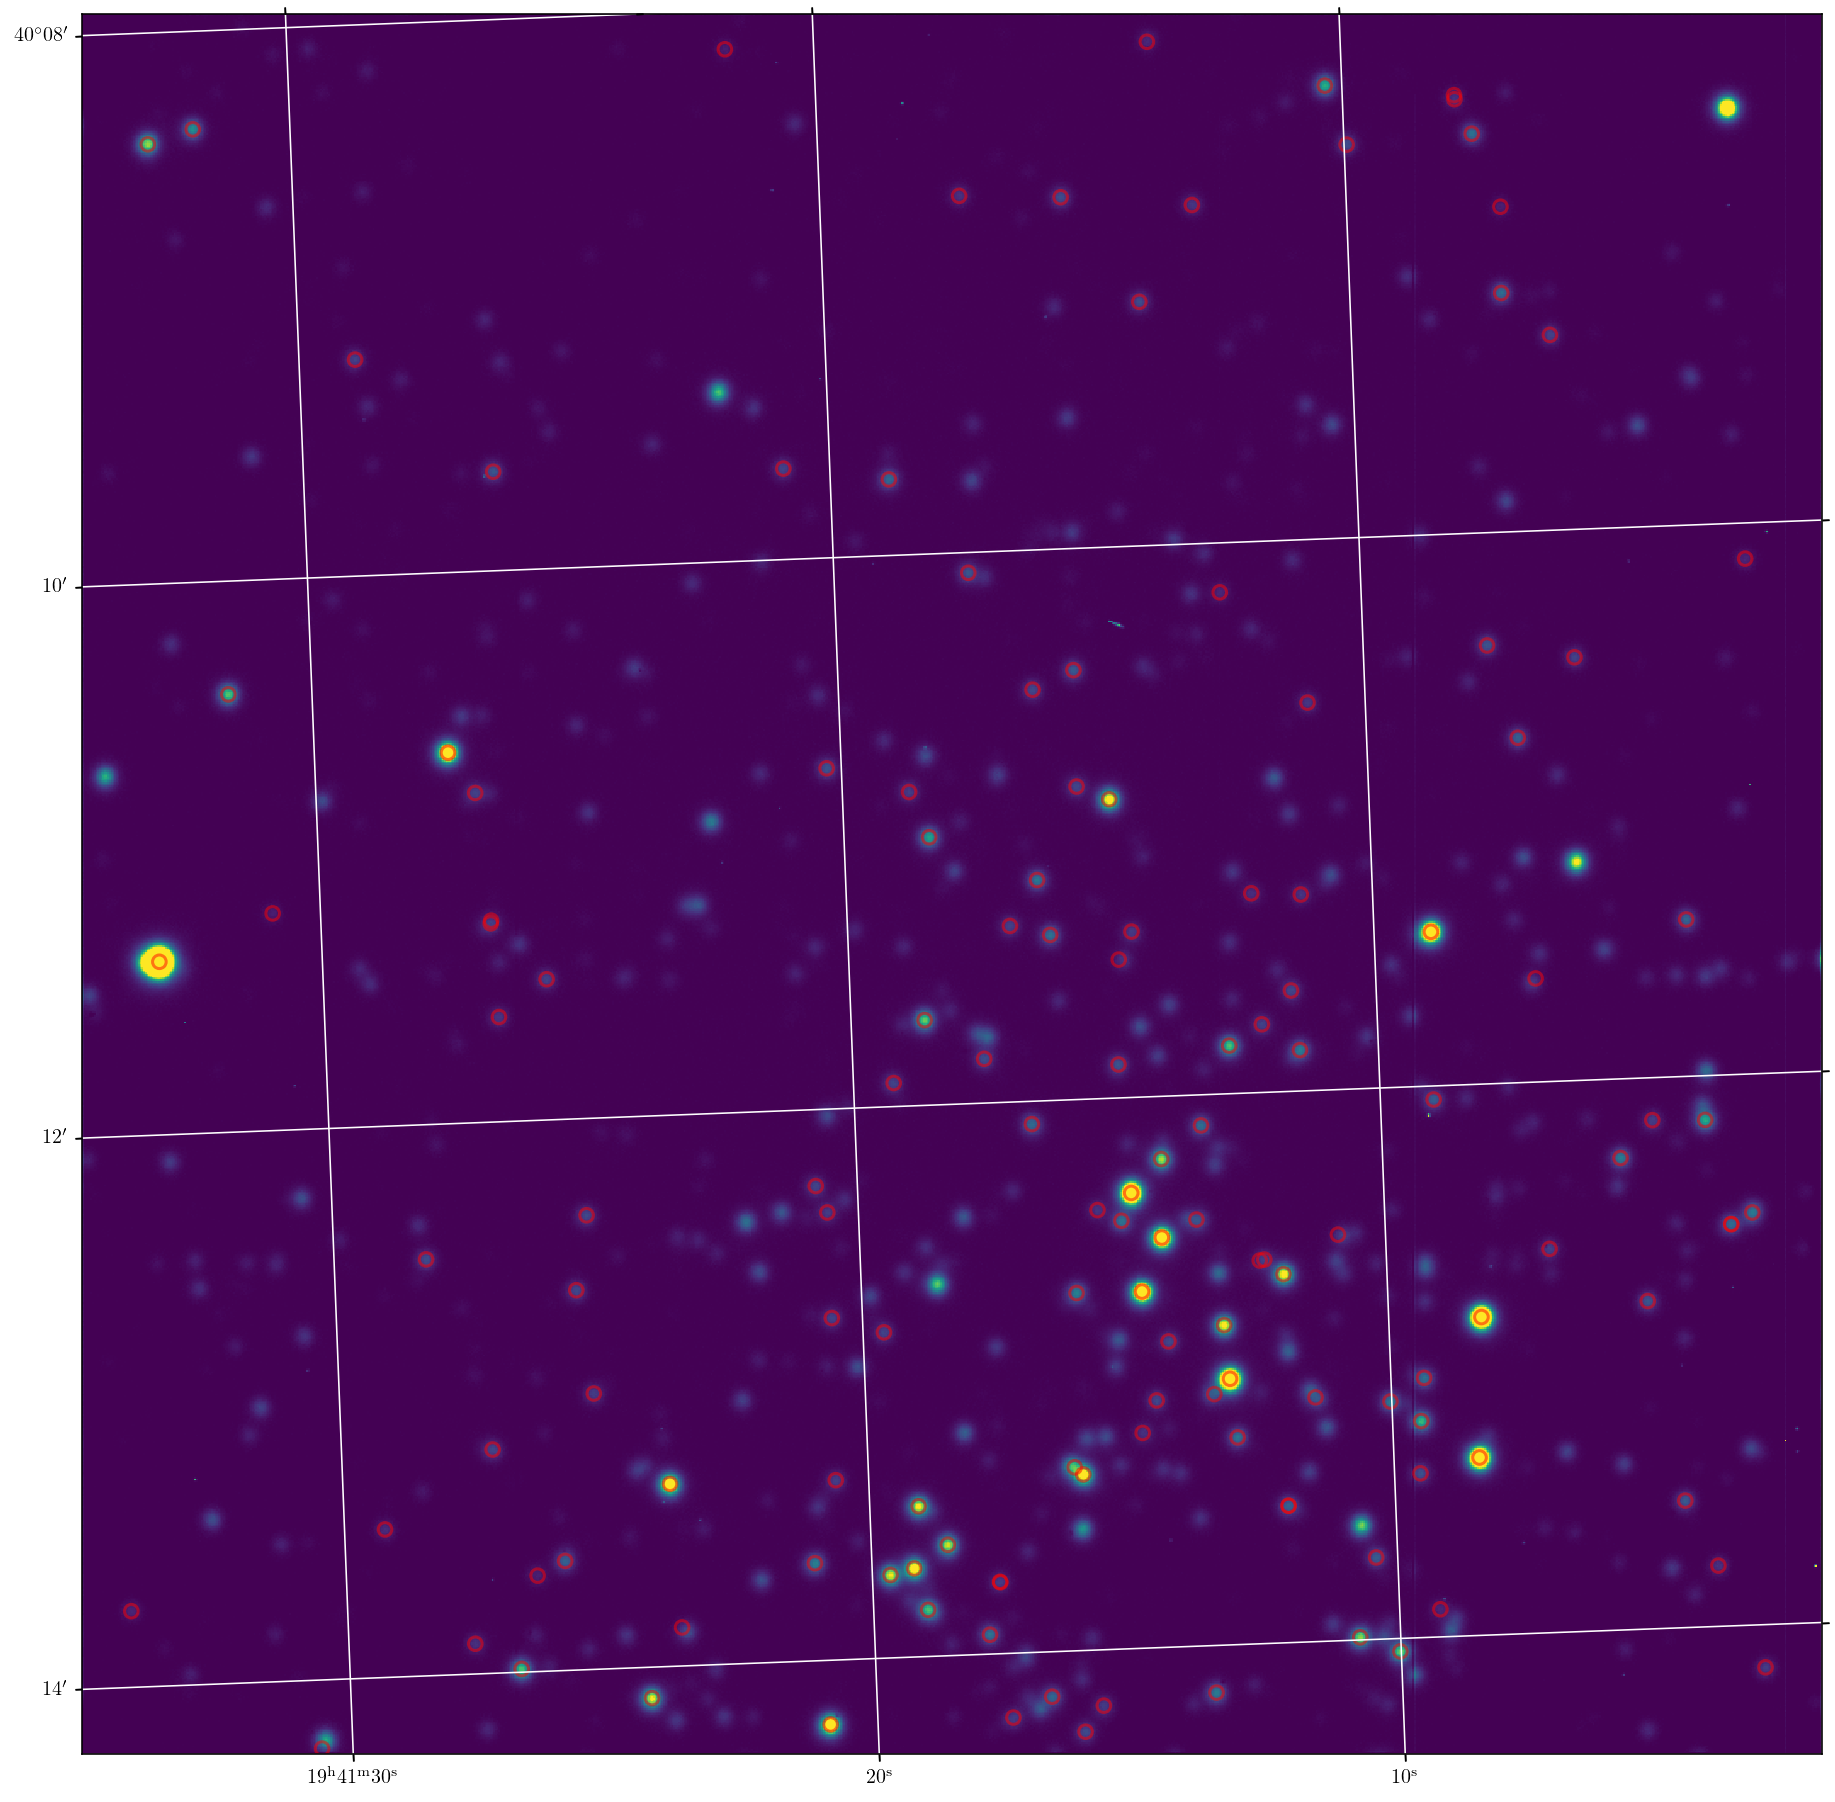

In [33]:
positions_b = np.transpose((sources_b['xcentroid'], sources_b['ycentroid']))
apertures_b = CircularAperture(positions_b, r=4.)

plt.figure(figsize=(16, 16))
plt.subplot(projection=wcs_b)
plt.grid(color='white', ls='solid')
plt.imshow(ngc6819_b - median_b, origin='lower', vmin=0, vmax=3000)
apertures_b.plot(color='red', lw=1.5, alpha=0.5)

## Landolt fields in V and B

## Landolt V

In [11]:
landolt_wcs_v = WCS(landolt_v_header)

landolt_mean_v, landolt_median_v, landolt_std_v = sigma_clipped_stats(landolt_v, sigma=3.0) # Background statistics

# Adjust these params by hand/eye
daofind = DAOStarFinder(fwhm=3.0, threshold=20.*landolt_std_v, sharplo=0.0, sharphi=.75, 
                        roundlo=-0.4, roundhi=0.4, peakmax=5e4, exclude_border=True)
landolt_sources_v = daofind(landolt_v - landolt_median_v)
for col in landolt_sources_v.colnames:
    landolt_sources_v[col].info.format = '%.8g'  # for consistent table output
print(landolt_sources_v)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  1 297.71924 89.406535 0.35861415 ...   0 1363.6879 2.2380548 -0.87467679
  2  221.3688 254.58605 0.37897973 ...   0 3581.6395 5.3890543  -1.8287814
  3 810.04689 399.78868 0.42106515 ...   0 757.59127 1.3755315 -0.34617634


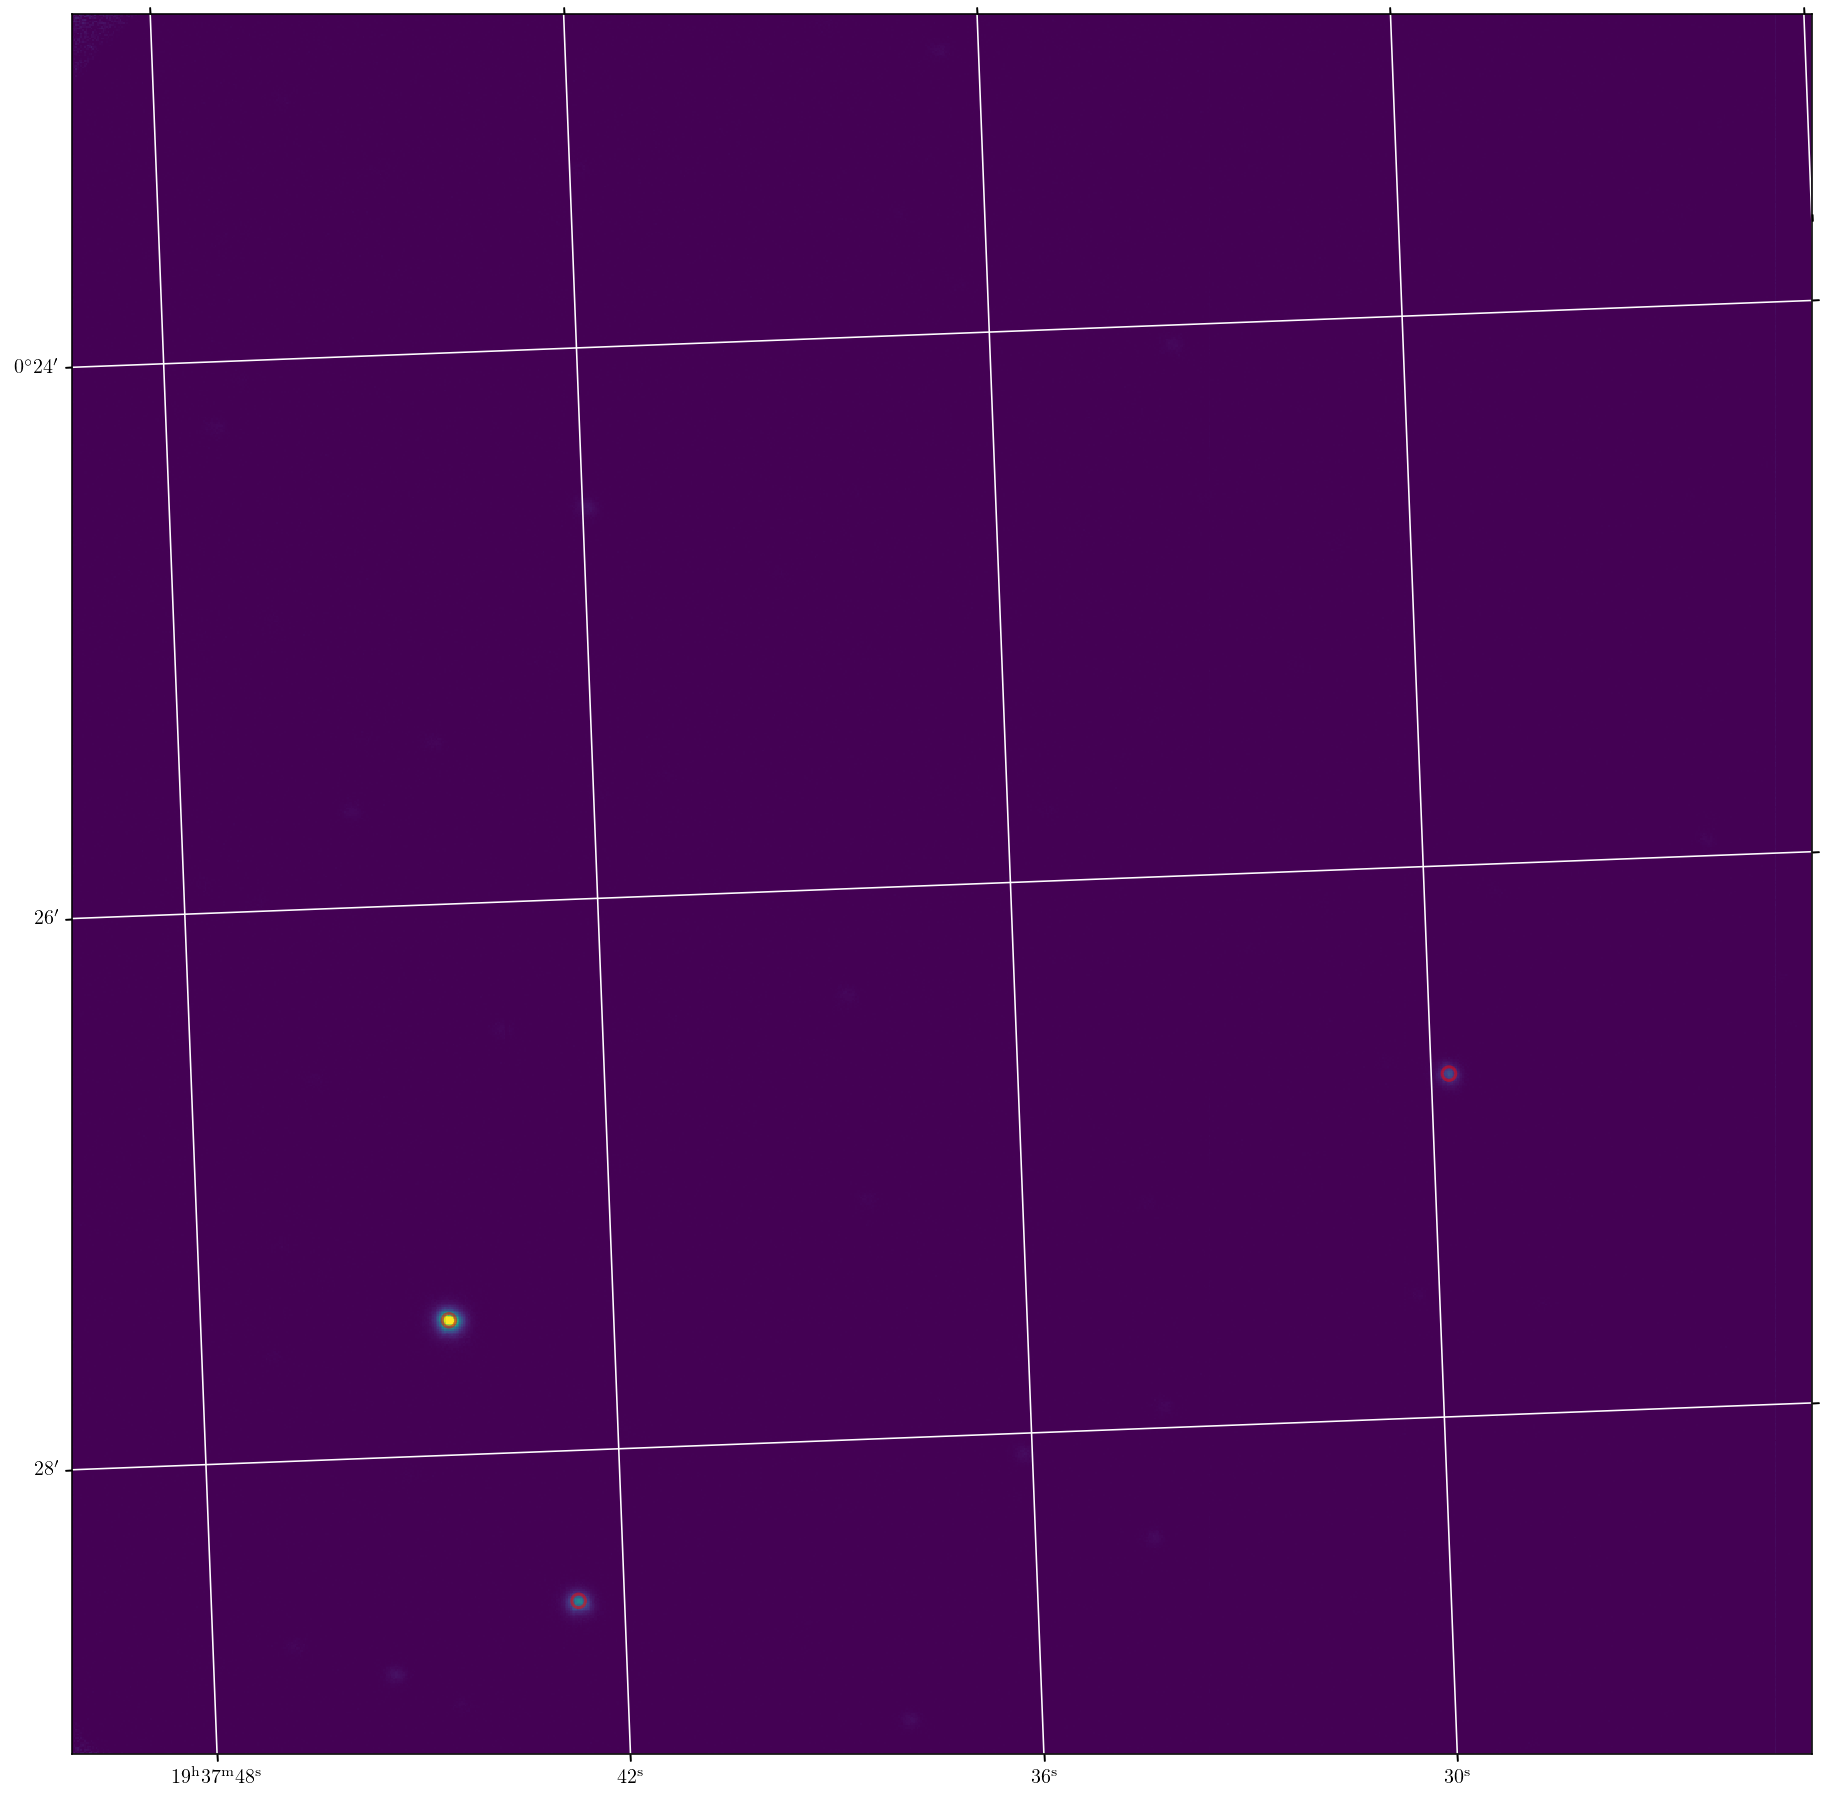

In [82]:
landolt_positions_v = np.transpose((landolt_sources_v['xcentroid'], landolt_sources_v['ycentroid']))
landolt_apertures_v = CircularAperture(landolt_positions_v, r=4.)

plt.figure(figsize=(16, 16))
plt.subplot(projection=landolt_wcs_v)
plt.grid(color='white', ls='solid')
plt.imshow(landolt_v - landolt_median_v, origin='lower', vmin=0, vmax=3000)
landolt_apertures_v.plot(color='red', lw=1.5, alpha=0.5)

## Landolt B

In [12]:
landolt_wcs_b = WCS(landolt_b_header)

landolt_mean_b, landolt_median_b, landolt_std_b = sigma_clipped_stats(landolt_b, sigma=3.0) # Background statistics

# Adjust these params by hand/eye
daofind = DAOStarFinder(fwhm=3.0, threshold=9.*landolt_std_b, sharplo=0.0, sharphi=.75, 
                        roundlo=-0.4, roundhi=0.4, peakmax=5e4, exclude_border=True)
landolt_sources_b = daofind(landolt_b - landolt_median_b)
for col in landolt_sources_b.colnames:
    landolt_sources_b[col].info.format = '%.8g'  # for consistent table output
print(landolt_sources_b)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
  1 292.79669  86.76787 0.33319666 ...   0 344.78158 1.0243644 -0.026136221
  2 219.79193 252.78726 0.43987806 ...   0 951.45273 3.2540581   -1.2810632
  3 807.65436 398.55317 0.35408834 ...   0 651.29342 1.7595925  -0.61353023
  4  807.9389 398.20691 0.31792139 ...   0 629.21245 2.0529997  -0.78097219


 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
  1 292.79669  86.76787 0.33319666 ...   0 344.78158 1.0243644 -0.026136221
  2 219.79193 252.78726 0.43987806 ...   0 951.45273 3.2540581   -1.2810632
  3 807.65436 398.55317 0.35408834 ...   0 651.29342 1.7595925  -0.61353023


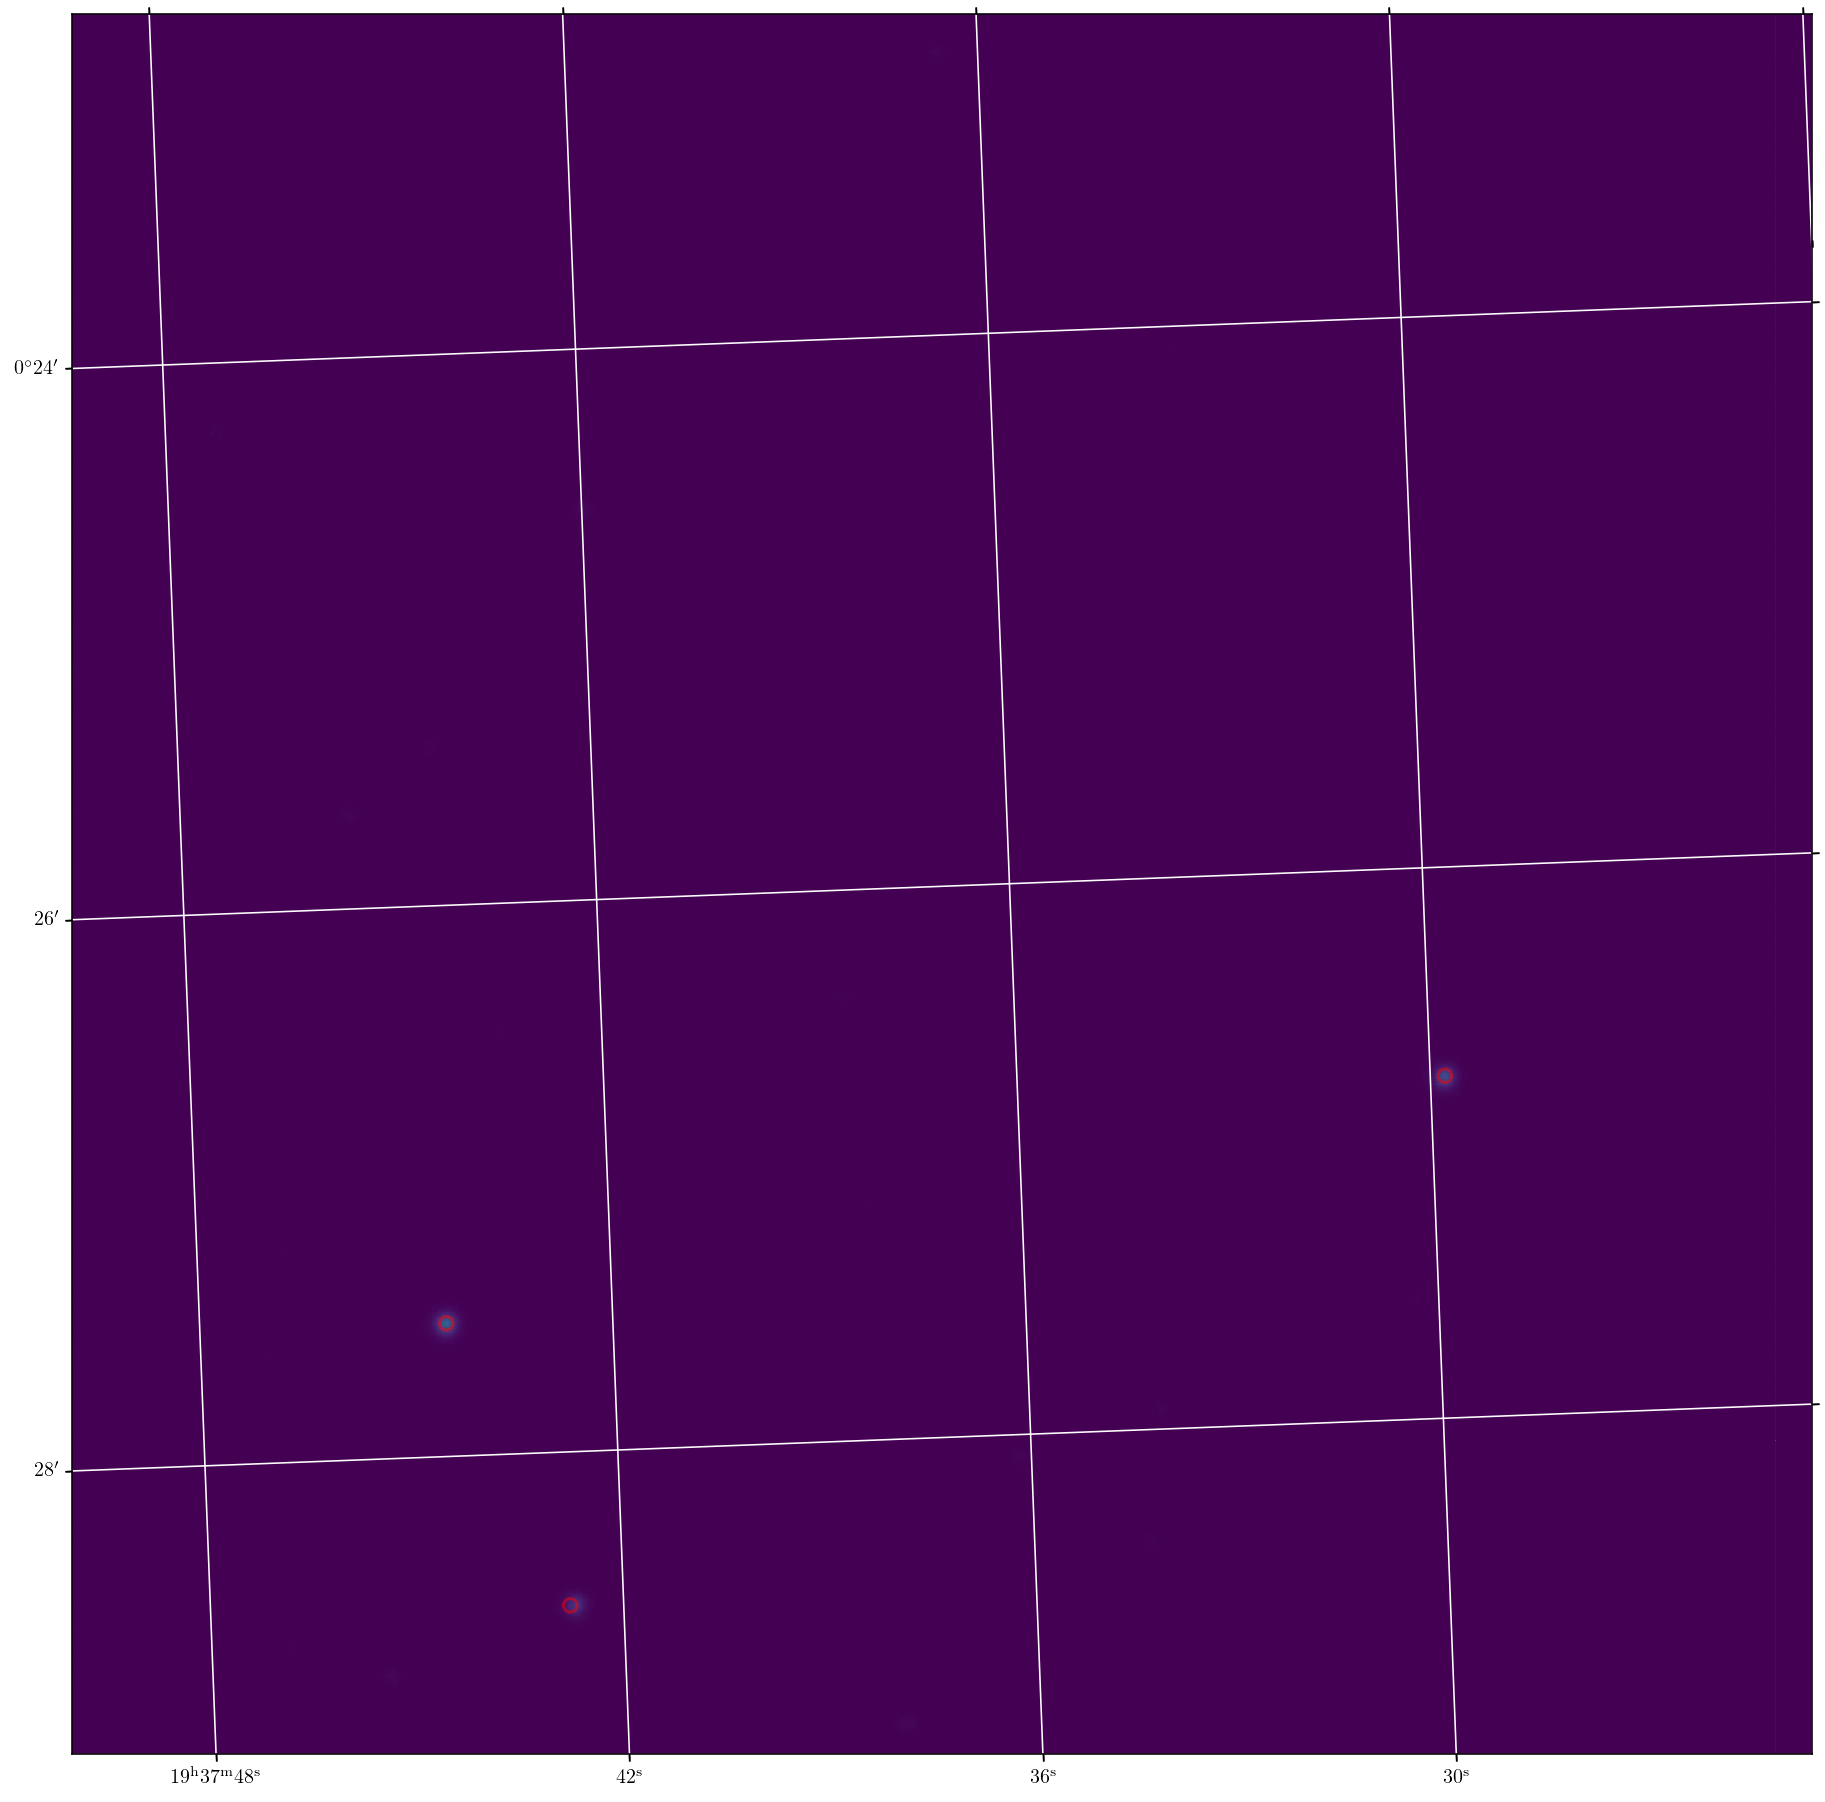

In [13]:
landolt_sources_b = landolt_sources_b[:-1]
print(landolt_sources_b)
landolt_positions_b = np.transpose((landolt_sources_b['xcentroid'], landolt_sources_b['ycentroid']))
landolt_apertures_b = CircularAperture(landolt_positions_b, r=4.)

plt.figure(figsize=(16, 16))
plt.subplot(projection=landolt_wcs_b)
plt.grid(color='white', ls='solid')
plt.imshow(landolt_b - landolt_median_b, origin='lower', vmin=0, vmax=3000)
landolt_apertures_b.plot(color='red', lw=1.5, alpha=0.5)

## Save the source tables

In [18]:
sources_v

<Table length=369>
  id  xcentroid ycentroid sharpness  ...    peak      flux       mag     
int64  float64   float64   float64   ...  float64   float64    float64   
----- --------- --------- ---------- ... --------- --------- ------------
    1 143.35212 9.1571939 0.40874652 ... 12877.242 32.290006   -3.7726703
    2 535.01009 13.916704  0.4188065 ... 378.94889 1.0524402 -0.055493577
    3 590.37276 13.775664 0.34722236 ... 2644.1912 6.3745064   -2.0111164
    4 440.35432 18.137437 0.41645396 ... 39287.159  100.2505   -5.0027164
    5 349.59645 21.009628 0.32530403 ... 1630.6669 4.0855958   -1.5281385
    6 377.73589 23.124704 0.47664187 ... 1609.0346 4.3311413   -1.5915059
    7 394.78188 23.116244 0.36072613 ... 652.40885 1.6619676  -0.55155636
    8 563.89782 27.717629 0.38889609 ... 3045.0081 6.8662614   -2.0918008
    9 601.41376 29.162382 0.34497476 ... 2044.9028 5.1167776   -1.7724914
   10 654.24705 30.487961 0.36706802 ...  884.9644 2.6954585   -1.0765816
  ...       ...       ...        ... ...       ...       ...          ...
  360  692.9663 964.63932 0.49423096 ... 365.98457 1.0471091 -0.049979836
  361 968.26888 970.15104 0.41721209 ... 20151.961 52.589052   -4.3022383
  362 807.48332 975.38714  0.4022905 ... 1787.0684 4.8335947   -1.7106756
  363  837.5144 979.30135 0.36496038 ... 668.10094  1.699848  -0.57602523
  364 731.31902 983.36066 0.44082644 ... 11381.998  29.65133   -3.6801104
  365 167.55472 991.81316 0.30863301 ... 732.63423 2.1997538  -0.85593517
  366 112.20975 1001.4081 0.37666736 ... 502.85144 1.4034804  -0.36801585
  367 133.23849 1004.6012 0.28278253 ... 868.70279 2.1595225  -0.83589431
  368 378.11002 1004.6157 0.43666185 ... 1040.6318 2.7230451   -1.0876371
  369 626.69845 1009.7669 0.38060807 ... 1335.3663   3.78837    -1.446131

In [17]:
import astropy
astropy.table.table.Table.write?

In [ ]:
# Save the tables to be read later
sources_v.write('sources_v.dat', format='ascii')
sources_b.write('sources_b.dat', format='ascii')